![](Scanpy_logo.svg){width=50% fig-align="center"}

# 들어가며

공개된 scRNA-seq 데이터를 다운로드 하다보면 `gene_symbol`을 포함하지 않고 `gene_id`만 있는 경우를 만나게 됩니다. 그런 경우 몇가지 불편한 점이 생깁니다. 예를 들면 해석의 어려움으로 `gene_id`만 있는 데이터셋은 사람이 직관적으로 해석하기 어렵습니다. 반면에 `gene_symbol`은 보다 익숙하고 이해하기 쉬운 경우가 많기 때문에 분석 및 결과의 시각화에 용이합니다. 그래서 이번 포스트에서는 `pybiomart`를 사용해 `gene_symbol`를 추가하는 작업을 해보겠습니다.

:::{.callout-note}
일부 유전자에는 여러 개의 Ensembl ID가 있습니다.  따라서 유전자 기호를 Ensembl ID로 자주 변경했다가는 오류가 발생할 가능성이 큽니다. 결과적으로 일부 유전자가 올바르게 식별되지 않을 수 있습니다.
:::

## pybiomart?

`pybiomart`의 목적은 파이썬에서 [BioMart](https://asia.ensembl.org/info/data/biomart/index.html) 데이터베이스를 쉽게 접근할 수 있게 간단한 인터페이스를 제공하는 것으로 `R`에서 `biomaRt`와 유사한 기능을 제공하는 것을 목표로 합니다. 다음 콘다 명령어를 통해 설치할 수 있습니다.

```shell
conda install pybiomart
```

# 예제 데이터셋 불러오기

`Scanpy`의 `datasets.ebi_expression_atlas`함수를 사용하면 EBI Single Cell Expression Atlas의 데이터를 가져와 `AnnData`객체로 바로 만들 수 있습니다.

먼저 필요한 라이브러리를 불러옵니다.

In [1]:
import warnings

import pandas as pd
import scanpy as sc

# 경고 무시
warnings.simplefilter("ignore")

In [2]:
adata = sc.datasets.ebi_expression_atlas("E-MTAB-9467")
adata

AnnData object with n_obs × n_vars = 39638 × 21893
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[ethnic group]', 'Sample Characteristic Ontology Term[ethnic group]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[age]', 'Sample Characteristic Ontology Term[age]', 'Sample Characteristic[developmental stage]', 'Sample Characteristic Ontology Term[developmental stage]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[cell type]', 'Sample Characteristic Ontology Term[cell type]', 'Sample Characteristic[clinical history]', 'Sample Characteristic Ontology Term[clinical history]', 'Factor Value[clinical history]', 'Factor Value Ontology Ter

위 출력을 통해 총 39,638개의 세포와 21,893개의 유전자 정보가 포함되어 있다는 것을 알 수 있습니다. 그리고 세포의 주석(`obs`항목)이 아주 많다는 것을 알 수 있네요.

## AnnData 객체에 대하여

`Scanpy`에서 사용되는 `AnnData` 객체는 개별 세포/유전자 주석 데이터를 저장하는 데이터 구조입니다.`AnnData` 객체는 크게 네 가지 주요 구성 요소로 구성됩니다.

- `adata.X`는 세포 x 유전자 레이아웃에서 유전자 발현 카운트 정보를 저장.
- `adata.obs`는 세포 주석을 가리키며, 세포 유형, 총 카운트, 클러스터 ID 등이 `Pandas` 데이터프레임 형태로 저장. 일반적으로 색인은 세포 바코드를 사용.
- `adata.var`는 유전자 주석을 가리키며, 유전자 ID, 유전자 심볼, 해당 유전자가 높은 변동성을 가지고 있는지 여부 등이 데이터프레임으로 저장.
- `adata.uns`는 세포나 유전자와 직접적으로 연결되지 않은 비구조적인 데이터를 포함. 예를 들면 KNN, PCA값 등이 있음.


## 세포 주석 살펴보기

In [3]:
adata.obs.head()

,Sample Characteristic[organism],Sample Characteristic Ontology Term[organism],Sample Characteristic[individual],Sample Characteristic Ontology Term[individual],Sample Characteristic[ethnic group],Sample Characteristic Ontology Term[ethnic group],Sample Characteristic[sex],Sample Characteristic Ontology Term[sex],Sample Characteristic[age],Sample Characteristic Ontology Term[age],...,Sample Characteristic[clinical history],Sample Characteristic Ontology Term[clinical history],Factor Value[clinical history],Factor Value Ontology Term[clinical history],Factor Value[sampling time point],Factor Value Ontology Term[sampling time point],Factor Value[inferred cell type - ontology labels],Factor Value Ontology Term[inferred cell type - ontology labels],Factor Value[inferred cell type - authors labels],Factor Value Ontology Term[inferred cell type - authors labels]
SAMEA7198212-AAAACCGCACAAGCCC,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,patient1,NaN,Thai,NaN,male,http://purl.obolibrary.org/obo/PATO_0000384,35 year,NaN,...,secondary DENV-4 infection,NaN,secondary DENV-4 infection,NaN,one day before defervescence,NaN,NaN,NaN,NaN,NaN
SAMEA7198212-AAAACCGTCATTGCGA,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,patient1,NaN,Thai,NaN,male,http://purl.obolibrary.org/obo/PATO_0000384,35 year,NaN,...,secondary DENV-4 infection,NaN,secondary DENV-4 infection,NaN,one day before defervescence,NaN,NaN,NaN,NaN,NaN
SAMEA7198212-AAAACTCCAAGGTGTG,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,patient1,NaN,Thai,NaN,male,http://purl.obolibrary.org/obo/PATO_0000384,35 year,NaN,...,secondary DENV-4 infection,NaN,secondary DENV-4 infection,NaN,one day before defervescence,NaN,NaN,NaN,NaN,NaN
SAMEA7198212-AAAACTCCAGCGTCCA,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,patient1,NaN,Thai,NaN,male,http://purl.obolibrary.org/obo/PATO_0000384,35 year,NaN,...,secondary DENV-4 infection,NaN,secondary DENV-4 infection,NaN,one day before defervescence,NaN,NaN,NaN,NaN,NaN
SAMEA7198212-AAAATGATCCTAGGGC,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,patient1,NaN,Thai,NaN,male,http://purl.obolibrary.org/obo/PATO_0000384,35 year,NaN,...,secondary DENV-4 infection,NaN,secondary DENV-4 infection,NaN,one day before defervescence,NaN,NaN,NaN,NaN,NaN


# 유전자 주석 살펴보기

유전자의 이름이 `ensembl_gene_id`로 되어 있는 것은 아래 코드로 확인할 수 있습니다.

In [4]:
adata.var.head()

""
ENSG00000000003
ENSG00000000419
ENSG00000000457
ENSG00000000460
ENSG00000000938


위 결과로 이 데이터셋에는 `gene_symbol`의 정보는 포함되어 있지않고 오직 `ensembl_gene_id`형태의 값만 있다는 것을 알 수 있습니다. 이 값들은 사람이 해석하기는 너무 힘들죠.

# gene_symbol 데이터 추가하기

`sc.queries.biomart_annotations`함수를 사용합니다.

In [5]:
# 유전자 기호를 검색합니다. requires pybiomart
annot = sc.queries.biomart_annotations(
    org="hsapiens",  # Organism to query "hsapiens", "mmusculus"
    attrs=["ensembl_gene_id", "external_gene_name"],  # Attributes to query biomart for
).set_index("ensembl_gene_id")

# 주석에 없는 유전자를 필터링합니다
adata = adata[:, adata.var.index.intersection(annot.index)]

# 유전자 기호를 할당합니다
adata.var["gene_symbol"] = [
    annot.loc[ensembl_id, "external_gene_name"] for ensembl_id in adata.var.index
]
adata.var = (
    adata.var.reset_index().rename(columns={"index": "ensembl_gene_id"}).set_index("gene_symbol")
)

# 유전자 기호가 없는 유전자를 제거합니다
adata = adata[:, ~pd.isnull(adata.var.index)]

# 중복된 유전자 기호의 이름을 변경합니다
adata.var_names_make_unique()

이제 어떻게 변경되었는지 확인해봅니다.

In [6]:
adata.var.head()

,ensembl_gene_id
gene_symbol,
TSPAN6,ENSG00000000003
DPM1,ENSG00000000419
SCYL3,ENSG00000000457
FIRRM,ENSG00000000460
FGR,ENSG00000000938


이제 `ensembl_gene_id`뿐만 아니라 `gene_symbol` 정보도 포함되어 있습니다.

# 가장 발현 비율이 높은 유전자 시각화

모든 세포에서 평균적으로 발현이 가장 높은 상위 20개의 유전자를 살펴보죠.

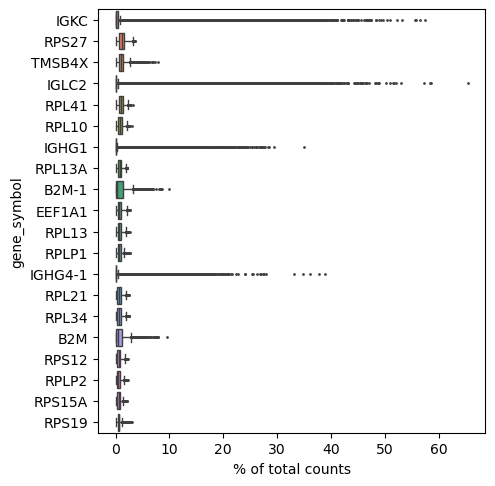

In [7]:
# iteritems 메서드가 판다스 2.0에서 제거되어 생기는 오류를 회피
pd.DataFrame.iteritems = pd.DataFrame.items

sc.pl.highest_expr_genes(adata, n_top=20)

결과를 자세히 보면 `B2M`, `B2M-1`이 따로 분리되어 있는 것을 볼 수 있습니다. 이건 앞서 이야기한 일부 유전자에 여러 개의 Ensembl ID가 있는 문제에서 비롯됩니다. 즉, `B2M`유전자가 2개 이상의 `Ensembl ID`를 갖고 있기 때문입니다.

# 파일 저장하기

다음번에 사용하기 위해 아래 코드로 `AnnData`객체를 저장합니다.

In [8]:
adata.write_h5ad("../output/" + "E-MTAB-9467.h5ad", compression="gzip")

# 나가며

`B2M`과 `B2M-1` 유전자가 완전히 동일한 것일까요? 그렇다면 서로 합치는 것이 좋지 않을까요? 하지만 합치면서 잃게되는 데이터는 어떻게 처리해야 할까요? 이것은 해결하기 어려운 문제입니다. 명확하고 정확한 표준 명명법이 있었다면 이런 문제가 발생하지 않았을 것이라고 생각됩니다. 하지만 항상 새로운 발견과 오류가 생기는 분야에서 애초에 그것은 불가능이지 아니었을까요?